# Intro to Audio Processing

We will explore some typical ways that we can process audio, and things to keep in mind when we are training Neural Networks on Audio data. 

When it comes to audio data, there are a few things to keep in mind about it:

- Sampling Rate (Hz): How many samples is in every second of audio?
- Duration: How many seconds is the audio?

We will be using ```torchaudio``` to load our data, you could also use another popular package called ```librosa```! I have an audio file here called *sample_audio.flac* that I got from the popular [librispeech](https://www.openslr.org/12) dataset. Lets go ahead and load and plot it!

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchaudio.transforms as T

audio, sampling_rate = torchaudio.load("sample_audio.flac")

### Remove batch dimension from audio for now ###
audio = audio.squeeze()

print("Audio:", audio)
print("Sampling Rate:", sampling_rate)
print("Total Samples in Audio:", len(audio))
print("Total Duration:", len(audio) / sampling_rate, "seconds")

Audio: tensor([0.0007, 0.0005, 0.0006,  ..., 0.0004, 0.0004, 0.0003])
Sampling Rate: 16000
Total Samples in Audio: 140720
Total Duration: 8.795 seconds


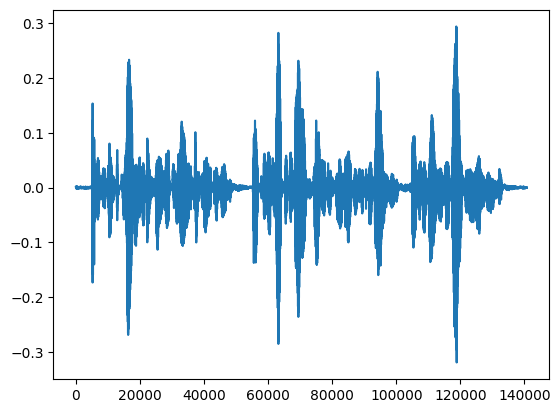

In [19]:
plt.plot(audio)
plt.show()

## Frequency Analysis

We can basically apply everything from the field of Signal Processing to speech! This means, the most important, is the Fourier Transform. If you don't know what the Fourier Transform is, watch this incredible video from [3Blue1Brown](https://youtu.be/spUNpyF58BY?feature=shared) that will visualize whats happening way better than I could ever write!

But lets do a quick primer just to get familiar with it, and how we can perform the Fourier Transform in PyTorch!

### Fourier Transform

$$X(k) = \sum_{n=0}^{N-1} x(n) \cdot e^{-i \frac{2\pi}{N} k n}$$


where:
- X(k) is the DFT of the signal,
- x(n) is the input signal,
- N is the number of samples,
- k is the frequency index,
- $e^{-i \frac{2\pi}{N} k n}$ is the complex exponential term.


We will be specifically working with the Discrete Fourier Transform (as our digital signals are sampled discretely), but they also have continuous ones that can be used for analog signals or anything else!

A Fourier Transform converts something from the Time (or Space) domain to the Frequency Domain. But what is frequency? Frequency is the number of cycles of a sinusoid that happens in a single second. Lets see what these sinusoids can look like!

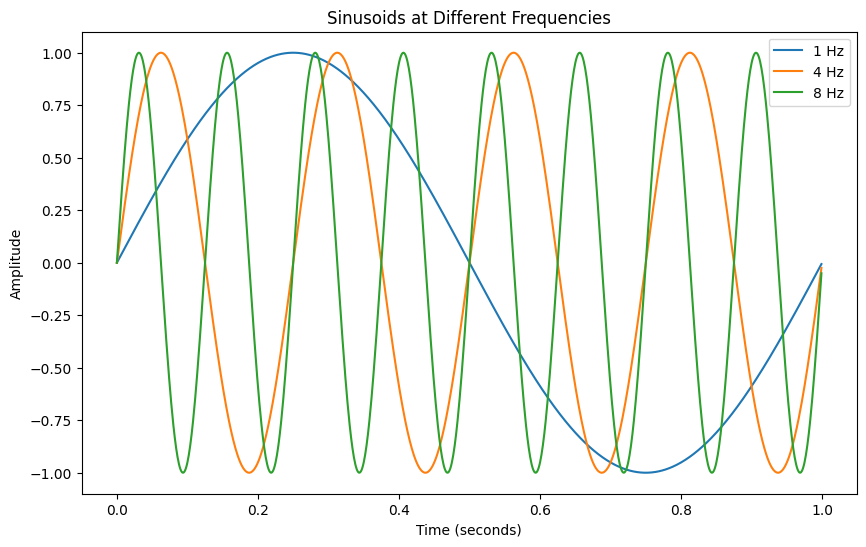

In [67]:
# Define parameters
t = np.linspace(0, 1, 1000, endpoint=False)  # Time vector (1 second, 1000 samples)
frequencies = [1, 4, 8]  # Different frequencies in Hz

# Plot sinusoids
plt.figure(figsize=(10, 6))
for f in frequencies:
    y = np.sin(2 * np.pi * f * t)
    plt.plot(t, y, label=f'{f} Hz')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Sinusoids at Different Frequencies')
plt.legend()
plt.show()

Lets take a look at the Fourier Transform! If we take a signal that we know has a frequency of 20, and apply a fourier transform to it, we should see a spike at 20Hz in the frequency domain and 0 elsewhere. 

In [68]:
# Define parameters
t = np.linspace(0, 1, 1000, endpoint=False)  # Time vector (1 second, 1000 samples)
f = 20  # Single frequency in Hz

# Generate sinusoid
y = np.sin(2 * np.pi * f * t)

# Compute Fourier Transform
y_fft = np.fft.fft(y)
freqs = np.fft.fftfreq(len(t), d=t[1] - t[0])

print(y_fft[:3])
print(freqs[:3])

[1.24413008e-14+0.00000000e+00j 9.75519027e-14+1.62719765e-14j
 1.65641165e-13+7.14152886e-14j]
[0. 1. 2.]


### What did it do?
The output of a fourier transform is always a complex number:

$$F(y) = A + jB$$

The $A$ is the real part representing the cosine component, and $B$ is the imaginary part, representing the sine component.

But really, we are just decomposing any signal into a sum of sinusoids (at different frequencies, magnitudes, and phase shifts). Its just dealing with sin and cosine is a pain (think back on all those trigonometry identies!). This is why we represent everything with Eulers Formula:

$$e^{i\theta} = \cos(\theta) + i\sin(\theta)$$

And this is where the complex number shows up!

We can extract two things from this: Magnitude of the different frequencies and the Phase that tells us the shift of the frequency component

$$Magnitude = |F(y)| = \sqrt{A^2 + B^2}$$
$$Phase = \theta = \tan^{-1}(\frac{B}{A})$$

### Negative Frequencies?

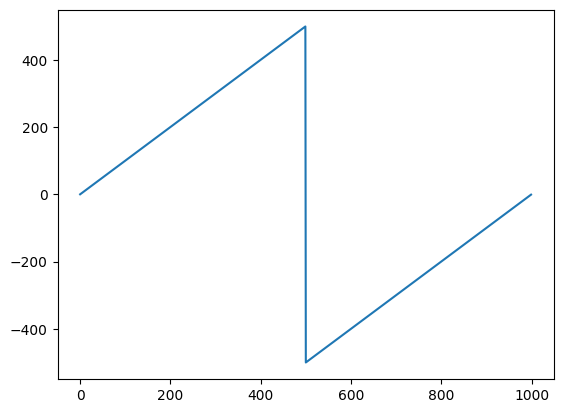

In [69]:
plt.plot(freqs)
plt.show()

Frequencies come in conjugate pairs, this means every frequency is paired with an identical negative frequency. We dont really care about them, so we typically only plot the positive frequencies

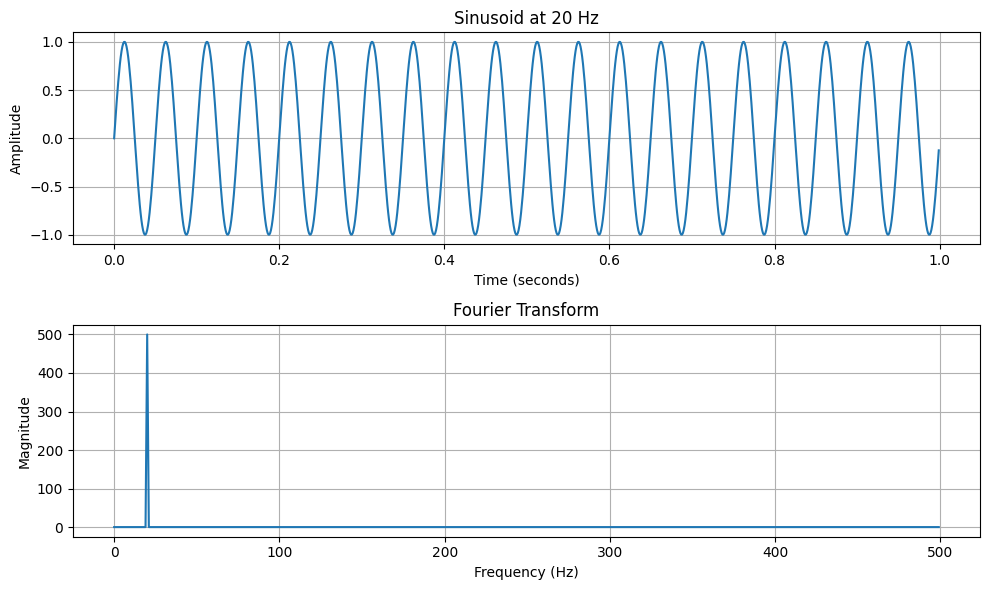

In [70]:
# Plot sinusoid
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, y)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Sinusoid at {f} Hz')
plt.grid(True)

# Plot Fourier Transform
plt.subplot(2, 1, 2)
plt.plot(freqs[:len(freqs)//2], np.abs(y_fft[:len(freqs)//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.grid(True)

plt.tight_layout()
plt.show()

### Nyquist-Shannon Sampling Theorem

A key part of signal processing is knowing what the maximum frequency a signal can represent. The theorem states that:

$$f_s > 2f_{max}$$

or the highest frequency a signal can represent is half the sampling rate. The signal we generated about had 1000 samples in 1 second, so the max frequency we can represent is 500! Can we see that in our data?

In [71]:
print("Max Frequency:", max(freqs))

Max Frequency: 499.0


This is especially important because, lets say you are recording audio for a song. The human hearing range typically goes to a frequency of about 20,000 , so we would need audio that is atleast 40,000 samples/second so we can contain all that information in nyquist. Typically we give ourselves a little buffer, and music will be recorded at about 44,100 samples/second.

When recording human speaking, the human voice has a much lower range, so we can use lower sampling rates like 16,000 samples/second

### Aliasing 

Unfortunately, this leads to a new issue: Aliasing. Lets say your audio is at 16,000 samples / second, and you have frequencies in it ranging all the way upto 5000. This means we can downsample our audio safely to 10,000 samples/second and maintain nyquist. But if we continue to downsample past that, then we start to lose frequeny information and Alias high frequencies to a different one. 

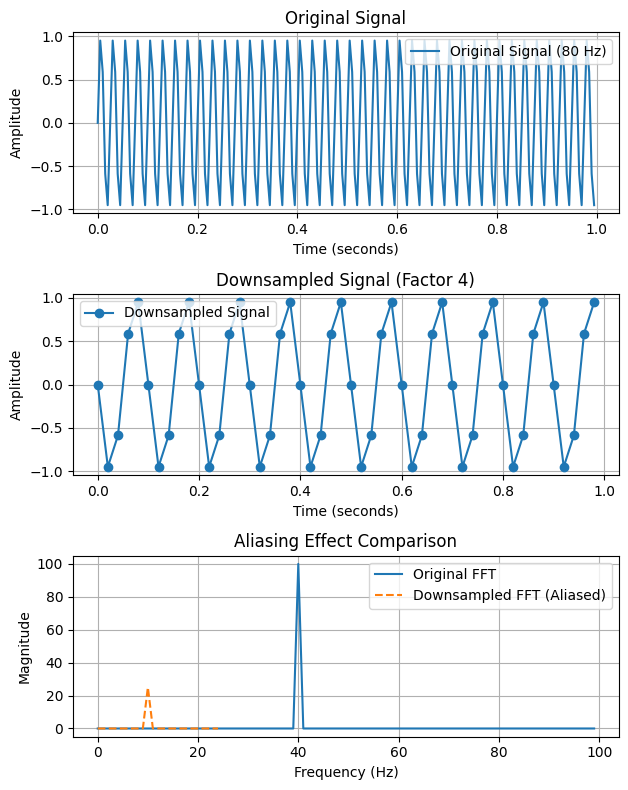

In [72]:
# Define parameters
t_high = np.linspace(0, 1, 200, endpoint=False)  # High-resolution time (1 second, 1000 samples)
f_original = 40  # Hz (Original frequency)

# Generate original sinusoid
y_high = np.sin(2 * np.pi * f_original * t_high)

# Compute Fourier Transform at high resolution
y_fft_high = np.fft.fft(y_high)
freqs_high = np.fft.fftfreq(len(t_high), d=t_high[1] - t_high[0])

# Downsampled version
downsample_factor = 4  # Reduce sampling rate by a factor of 4
t_low = t_high[::downsample_factor]
y_low = y_high[::downsample_factor]

# Compute Fourier Transform at lower sampling rate
y_fft_low = np.fft.fft(y_low)
freqs_low = np.fft.fftfreq(len(t_low), d=t_low[1] - t_low[0])

# Plot results
plt.figure(figsize=(12, 8))

# Original signal
plt.subplot(3, 2, 1)
plt.plot(t_high, y_high, label='Original Signal (80 Hz)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Original Signal')
plt.legend()
plt.grid(True)

# Downsampled signal
plt.subplot(3, 2, 3)
plt.plot(t_low, y_low, 'o-', label='Downsampled Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Downsampled Signal (Factor {downsample_factor})')
plt.legend()
plt.grid(True)


# Highlight aliasing effect
plt.subplot(3, 2, 5)
plt.plot(freqs_high[:len(freqs_high)//2], np.abs(y_fft_high[:len(freqs_high)//2]), label='Original FFT')
plt.plot(freqs_low[:len(freqs_low)//2], np.abs(y_fft_low[:len(freqs_low)//2]), '--', label='Downsampled FFT (Aliased)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Aliasing Effect Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Sum of Sinusoids

The coolest part about fourier transforms though is that, if we have a single, that is a mixture of multiple sinusoids, then the fourier transform can identify the frequency of all the the individual sinusoids that make it! For example:


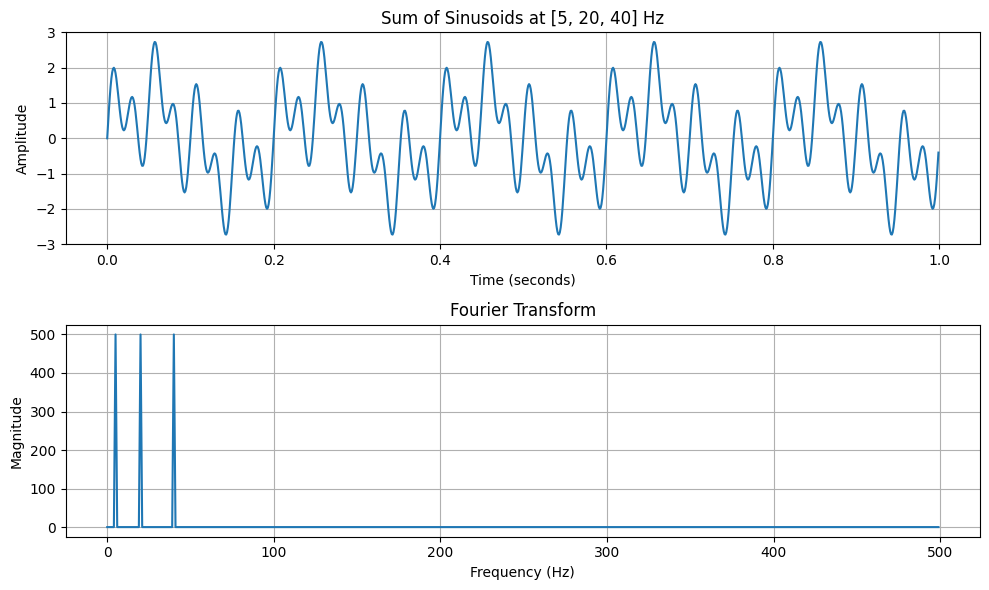

In [73]:
# Define parameters
t = np.linspace(0, 1, 1000, endpoint=False)  # Time vector (1 second, 1000 samples)
frequencies = [5, 20, 40]  # Multiple frequencies in Hz

# Generate sum of sinusoids
y = np.sum([np.sin(2 * np.pi * f * t) for f in frequencies], axis=0)

# Compute Fourier Transform
y_fft = np.fft.fft(y)
freqs = np.fft.fftfreq(len(t), d=t[1] - t[0])

# Plot summed sinusoids
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, y)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Sum of Sinusoids at {frequencies} Hz')
plt.grid(True)

# Plot Fourier Transform
plt.subplot(2, 1, 2)
plt.plot(freqs[:len(freqs)//2], np.abs(y_fft[:len(freqs)//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.grid(True)

plt.tight_layout()
plt.show()


### Inverse Transform

Can we go from frequency back to to the time domain? Of course! We can use the Inverse Fourier transform. We can pass in our complex values from the fourier transform to our inverse transform and get back the original signal! 

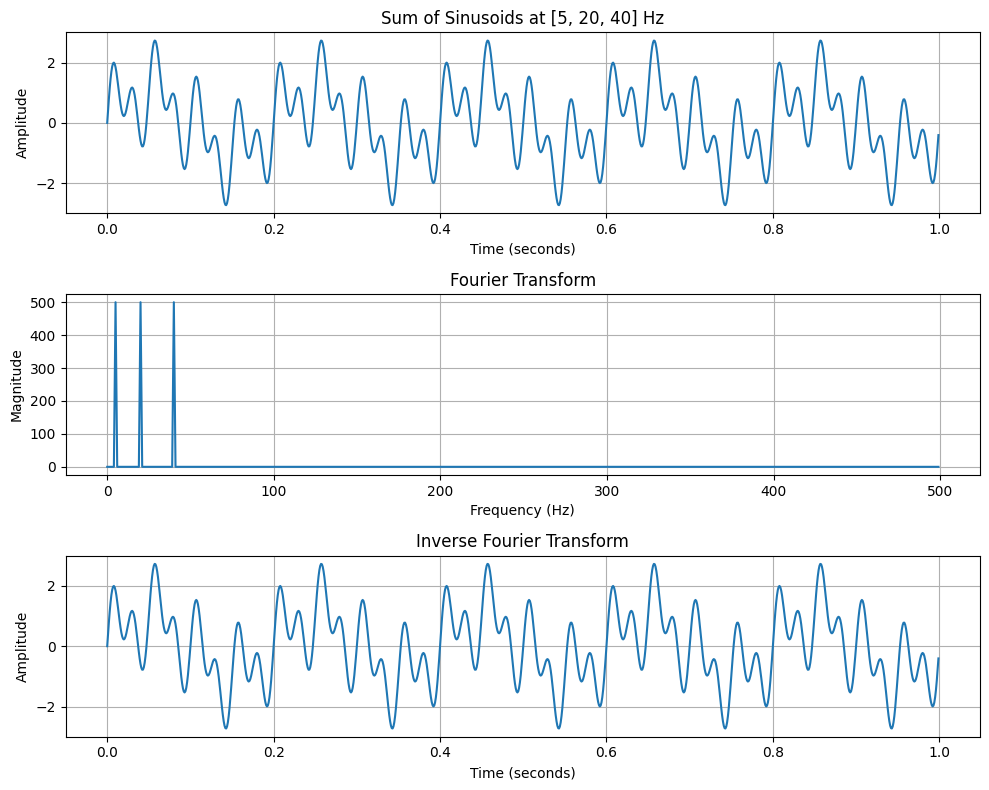

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
t = np.linspace(0, 1, 1000, endpoint=False)  # Time vector (1 second, 1000 samples)
frequencies = [5, 20, 40]  # Multiple frequencies in Hz

# Generate sum of sinusoids
y = np.sum([np.sin(2 * np.pi * f * t) for f in frequencies], axis=0)

# Compute Fourier Transform
y_fft = np.fft.fft(y)
freqs = np.fft.fftfreq(len(t), d=t[1] - t[0])

# Compute Inverse Fourier Transform
y_ifft = np.fft.ifft(y_fft).real

# Plot summed sinusoids
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(t, y)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Sum of Sinusoids at {frequencies} Hz')
plt.grid(True)

# Plot Fourier Transform
plt.subplot(3, 1, 2)
plt.plot(freqs[:len(freqs)//2], np.abs(y_fft[:len(freqs)//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.grid(True)

# Plot Inverse Fourier Transform
plt.subplot(3, 1, 3)
plt.plot(t, y_ifft)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Inverse Fourier Transform')
plt.grid(True)

plt.tight_layout()
plt.show()

### Spectrograms: Frequency vs Time

It seems like we are doing a full conversion here. We are either completely in the time domain or converting to the frequency domain. This is probably less useful to use though. In human speaking, what we are curious about is the frequency at different times of the audio! This is also known as a ```Short Time Fourier Transform``` (STFT). This is because we can learn that different combinations of frequencies typically make different sounds, which a Neural Network can pick up on to do things like Voice to Text.

A spectrogram is like a picture of the audio and the idea is very simple. Take an audio that has maybe 160000 samples at 16000 samples/second (10 seconds of audio) and compute the Fourier Transform that we saw above on small consecutive chunks of it. Then just put it all together into a plot!

Therefore, there a few things you have to decide:
- n_fft: How many samples do you want in every chunk?
- hop_length: How many samples do you want to move over every time?

Its pretty typically to have a 50% overlap, so the hop length is half the n_fft. 

#### Magnitude Only

Spectograms typically only return the magnitude of each frequency at the different timesteps and not the phase. Its not that we can't have the phase, but typically it is not relevant! So instead we simply return the magnitude of the frequencies. This will lead to a different problem later, but for now we can keep going!

Lets create a spectrogram on our audio from before:

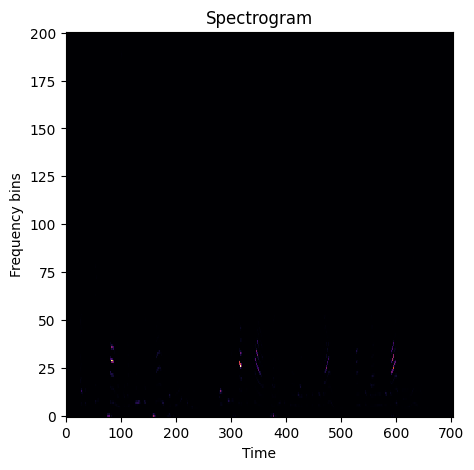

In [116]:
# Apply a regular Spectrogram transformation (not MelSpectrogram)
transform = T.Spectrogram(n_fft=400, hop_length=200)
spec = transform(audio)

# Plot the spectrogram
plt.figure(figsize=(5, 5))
plt.imshow(spec, cmap='inferno', origin='lower', aspect='auto', interpolation='none')
plt.title("Spectrogram")
plt.ylabel("Frequency bins")
plt.xlabel("Time")
plt.show()

That doesn't look like much... This is bceause instead of looking at raw amplitudes, we typically convert our spectrogram to decibels! This is basically a log scaling of our spectrogram (which is amplitude of the different frequencies) like the following

$$dB = 20 * \log_{10}(P)$$

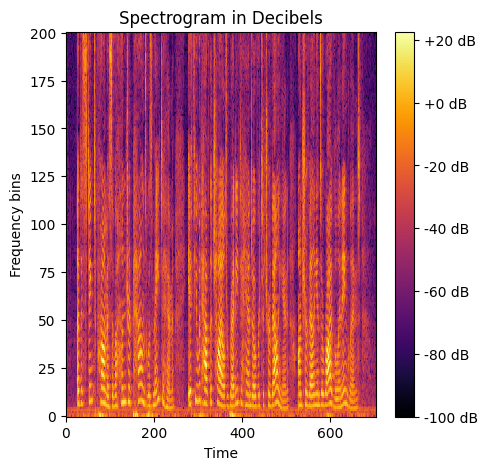

In [117]:
db_transform = T.AmplitudeToDB()
db_spec = db_transform(spec)

# Plot the decibel spectrogram
plt.figure(figsize=(5, 5))
plt.imshow(db_spec.numpy(), cmap='inferno', origin='lower', aspect='auto', interpolation='none')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram in Decibels")
plt.ylabel("Frequency bins")
plt.xlabel("Time")
plt.show()

### Mel Spectrogram

The Mel Spectrogram is very close to what we have done so far, but is a special type of spectrogram that uses a MEL Scale. This is a perceptual scale that spaces frequencies more widely at higher frequencies and more closer together at lower frequencies (therefore a non-linear frequency scale). The Mel Spectrogram is closer to the what the human ear percieves sound and is an approximation of our auditory perception. 

$$Mel(f) = 1127\ln(\frac{f}{700} + 1)$$

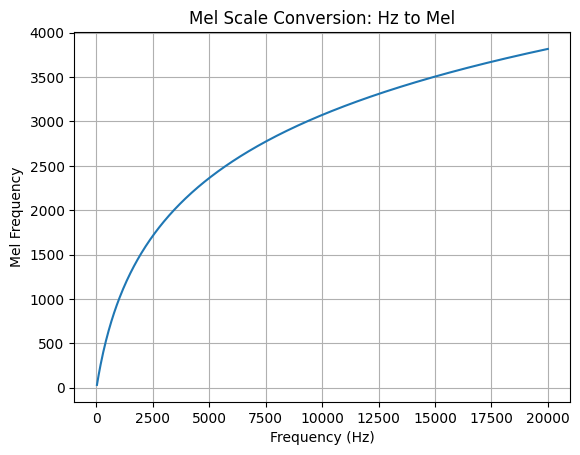

In [118]:
def hz_to_mel(f):
    return 1127 * np.log(1 + f / 700)

frequencies = np.linspace(20, 20000, 500)
mel_frequencies = hz_to_mel(frequencies)

plt.plot(frequencies, mel_frequencies)
plt.title('Mel Scale Conversion: Hz to Mel')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mel Frequency')
plt.grid(True)

### Create a Mel Spectrogram

There are some key arguments you need to set again:
- sample_rate: what is the sampling rate of the audio?
- n_fft: window size for the transform
- hop_length: how much to move every step?
- n_mels: larger n_mels gives higher frequency resolution and more detail, whereas fewer gives less detail. You can only generative n_mels upto the number of frequency bins from the FFT.
- mel_scale: There are slight differences in definitions for scaling for mel frequencies (slaney vs htk)

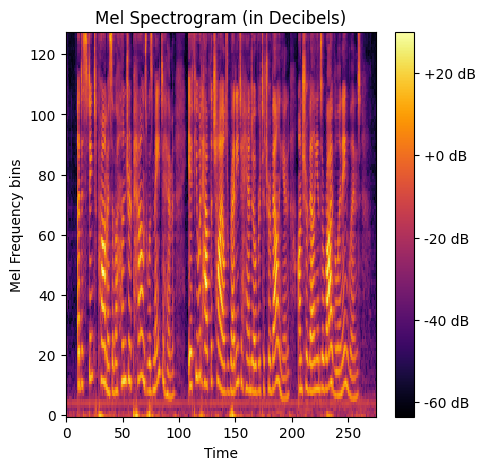

In [121]:
# Define MelSpectrogram transformation
transform = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,             # FFT window size
    hop_length=512,        # Hop length (stride)
    n_mels=128,             # Number of Mel bins
    mel_scale="slaney"        # Mel scale (HTK or Slaney)
)

# Apply the MelSpectrogram transform to the waveform
mel_spec = transform(audio)

# Convert the Mel spectrogram to decibels (dB)
db_transform = T.AmplitudeToDB()
mel_spec_db = db_transform(mel_spec)

# Plot the Mel spectrogram
plt.figure(figsize=(5, 5))
plt.imshow(mel_spec_db.numpy(), cmap='inferno', origin='lower', aspect='auto', interpolation='none')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram (in Decibels)")
plt.ylabel("Mel Frequency bins")
plt.xlabel("Time")
plt.show()

### The Problem of No Phase

In TTS systems (Text to Speech) a typical strategy is to use a Neural Network to predict this spectrogram! But this spectrogram is only the magnitude information of the original audio and not the phase. This prohibits us from directly doing an inverse short time fourier transform as we saw earlier, when we did the inverse of the fourier transform, we passed in the complex values as it contains both magnitude and phase information.

Therefore how do we inverse? The Griffin Lim Algorithm!

### Griffin-Lim Algorithm

The Griffin-Lim algorithm is an iterative method used for phase retrieval in the context of inverse spectrogram reconstruction. It is typically used to reconstruct a time-domain signal from a magnitude spectrogram when the phase information is missing.

Steps:

1) Start with an initial guess for the phase
2) Inverse STFT back to the waveform with the current phase guess
3) Take the STFT again back to the spectrogram
4) Rescale so the magnitude of our new spectrogram is the same as the original spectrogram.
5) Repeat when converged!

There are a lot of cool reasons this works, and you can explore this at my [professors slides!](https://courses.grainger.illinois.edu/ece417/fa2023/slides/lec06.pdf)

The main reason though is we are trying to solve a constrained optimization, and the way that STFT and Inverse STFT works, you are effectively doing projections between your constraints until you have solved the system. 

Maybe in the future I can do a simple implementation of this, but for now lets just use ```torchaudio```

### InverseMelScale

Griffin Lim only works on the linear scale spectrogram, not the Mel Scale, so we have to convert our Mel Spectrogram back to the linear scale, and then we can do griffin lim!

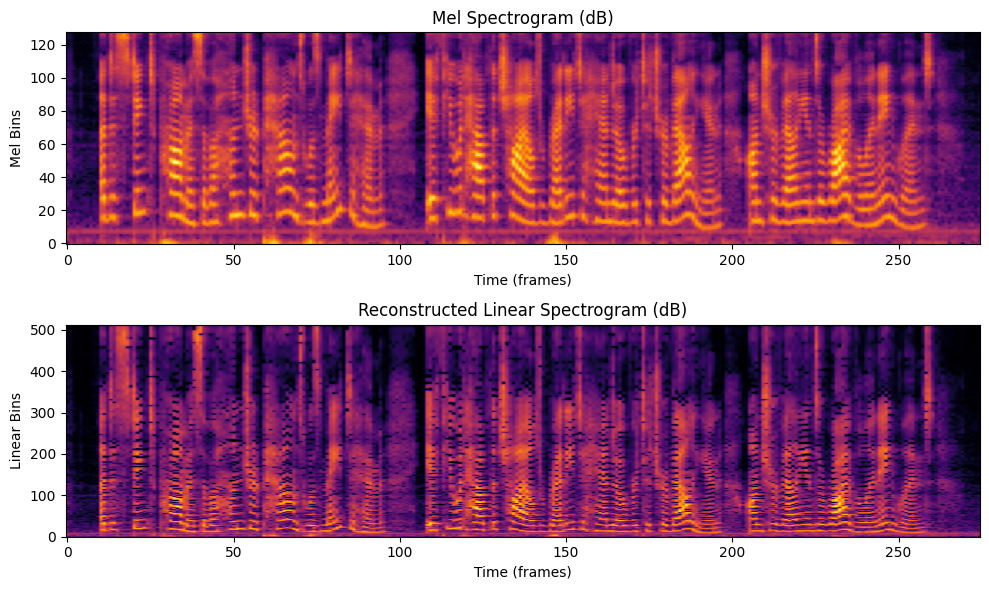

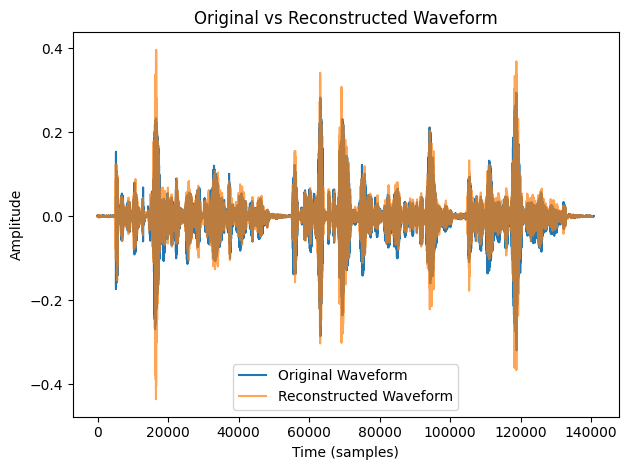

In [140]:

waveform, sample_rate = torchaudio.load("sample_audio.flac")

transform = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,             # FFT window size
    hop_length=512,        # Hop length (stride)
    n_mels=128,             # Number of Mel bins
    mel_scale="slaney"        # Mel scale (HTK or Slaney)
)

mel_spectrogram = mel_spectrogram_transform(waveform)

### Convert Mel to Linear ###
inverse_melscale_transform = T.InverseMelScale(n_stft=1024 // 2 + 1, 
                                               n_mels=mel_spectrogram.shape[1], 
                                               sample_rate=sample_rate)
spectrogram = inverse_melscale_transform(mel_spectrogram)

# Apply Griffin-Lim algorithm to reconstruct the waveform from the magnitude spectrogram
griffin_lim_transform = T.GriffinLim(n_fft=1024, hop_length=512, n_iter=100)
magnitude_spectrogram = spectrogram.abs()  # Get the magnitude of the spectrogram
reconstructed_waveform = griffin_lim_transform(magnitude_spectrogram)

# Plot the Mel spectrogram and the reconstructed regular spectrogram
plt.figure(figsize=(10, 6))

# Plot Mel Spectrogram (in dB)
plt.subplot(2, 1, 1)
plt.imshow(torch.log(mel_spectrogram[0] + 1e-6).numpy(), aspect='auto', origin='lower', cmap='inferno')
plt.title('Mel Spectrogram (dB)')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Bins')

# Plot the reconstructed Linear Spectrogram (in dB)
plt.subplot(2, 1, 2)
plt.imshow(torch.log(spectrogram[0] + 1e-6).numpy(), aspect='auto', origin='lower', cmap='inferno')
plt.title('Reconstructed Linear Spectrogram (dB)')
plt.xlabel('Time (frames)')
plt.ylabel('Linear Bins')

plt.tight_layout()
plt.show()

# Plot the Original and Reconstructed Waveforms
plt.plot(waveform.t().numpy(), label='Original Waveform')
plt.plot(reconstructed_waveform.t().numpy(), label='Reconstructed Waveform', alpha=0.7)
plt.title('Original vs Reconstructed Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


### Vocoders

Although Griffin Lim can create reasonable reconstructions from Magnitude Spectrograms to Audio, it isn't as good as Deep Learning based methods like HIFI-GAN. These are typically known as Vocoders (or speech synthesizers). We will be exploring how to build these in the future!


## Recap

You should have a good idea now about some of the techniques we use from Signal Processing to prep Audio data from training neural networks! There are still more stuff that we didn't discuss (MFCC, VAD, Formant Analysis, Pitch Detection, Speaker Identification, etc...) but we will get into all of this in the future!